![image info](https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/images/banner_1.png)

# Taller: Construcción e implementación de árboles de decisión y métodos de ensamblaje

En este taller podrá poner en práctica los sus conocimientos sobre construcción e implementación de árboles de decisión y métodos de ensamblajes. El taller está constituido por 9 puntos, 5 relacionados con árboles de decisión (parte A) y 4 con métodos de ensamblaje (parte B).

## Parte A - Árboles de decisión

En esta parte del taller se usará el conjunto de datos de Capital Bikeshare de Kaggle, donde cada observación representa el alquiler de una bicicleta durante una hora y día determinado. Para más detalles puede visitar los siguientes enlaces: [datos](https://github.com/justmarkham/DAT8/blob/master/data/bikeshare.csv), [dicccionario de datos](https://www.kaggle.com/c/bike-sharing-demand/data).

### Datos prestamo de bicicletas

In [410]:
import warnings
warnings.filterwarnings('ignore')

In [411]:
# Importación de librerías
%matplotlib inline
import pandas as pd
import numpy as np
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, export_graphviz
from sklearn.ensemble import BaggingClassifier
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, f1_score, accuracy_score
from sklearn import metrics
from sklearn.tree import plot_tree
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV

In [412]:
# Lectura de la información de archivo .csv
bikes = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/bikeshare.csv', index_col='datetime', parse_dates=True)
# Renombrar variable "count" a "total"
bikes.rename(columns={'count':'total'}, inplace=True)
# Crear la hora como una variable 
bikes['hour'] = bikes.index.hour
# Visualización
bikes.head()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,total,hour
datetime,,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16,0
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40,1
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32,2
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13,3
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1,4


### Punto 1 - Análisis descriptivo

Ejecute las celdas 1.1 y 1.2. A partir de los resultados realice un análisis descriptivo sobre las variables hour y workingday, escriba sus inferencias sobre los datos. Para complementar su análisis puede usar métricas como máximo, mínimo, percentiles entre otros.

In [413]:
bikes.shape

(10886, 12)

In [414]:
bikes.dtypes

season          int64
holiday         int64
workingday      int64
weather         int64
temp          float64
atemp         float64
humidity        int64
windspeed     float64
casual          int64
registered      int64
total           int64
hour            int64
dtype: object

In [415]:
# Celda 1.1
bikes.groupby('workingday').total.mean()

workingday
0    188.506621
1    193.011873
Name: total, dtype: float64

In [416]:
# Celda 1.2
bikes.groupby('hour').total.mean()

hour
0      55.138462
1      33.859031
2      22.899554
3      11.757506
4       6.407240
5      19.767699
6      76.259341
7     213.116484
8     362.769231
9     221.780220
10    175.092308
11    210.674725
12    256.508772
13    257.787281
14    243.442982
15    254.298246
16    316.372807
17    468.765351
18    430.859649
19    315.278509
20    228.517544
21    173.370614
22    133.576754
23     89.508772
Name: total, dtype: float64

In [417]:
bikes.groupby('workingday')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
workingday,,,,,,,,
0,3474.0,188.506621,173.724015,1.0,44.0,128.0,304.0,783.0
1,7412.0,193.011873,184.513659,1.0,41.0,151.0,277.0,977.0


In [418]:
bikes.groupby('hour')['total'].describe()

,count,mean,std,min,25%,50%,75%,max
hour,,,,,,,,
0,455.0,55.138462,43.620012,2.0,24.00,41.0,74.50,283.0
1,454.0,33.859031,34.112105,1.0,11.00,19.0,46.00,168.0
2,448.0,22.899554,26.110267,1.0,5.00,11.0,32.00,119.0
3,433.0,11.757506,12.666442,1.0,3.00,6.0,15.00,66.0
4,442.0,6.407240,4.217633,1.0,3.00,6.0,9.00,28.0
5,452.0,19.767699,12.784293,1.0,8.00,19.0,29.00,57.0
6,455.0,76.259341,54.745333,1.0,24.50,75.0,118.00,213.0
7,455.0,213.116484,159.207044,1.0,63.00,208.0,334.00,596.0
8,455.0,362.769231,231.723065,8.0,133.50,392.0,563.50,839.0


Observaciones:
* En promedio hay más alquileres de bicicleta en días laborales que en días no laborales
* Hay mucho menor cantidad de alquileres en horas de la madrugada, es decir durante las horas en donde la mayoría de personas están durmiendo.


### Punto 2 - Análisis de gráficos

Primero ejecute la celda 2.1 y asegúrese de comprender el código y el resultado. Luego, en cada una de celdas 2.2 y 2.3 escriba un código que genere una gráfica de las rentas promedio por hora cuando la variable "workingday" es igual a 0 e igual a 1, respectivamente. Analice y escriba sus hallazgos.

<AxesSubplot:xlabel='hour'>

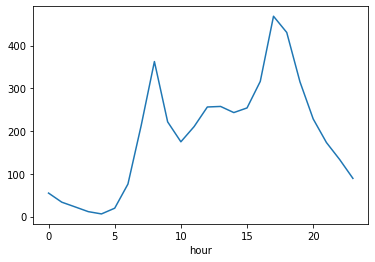

In [419]:
# Celda 2.1 - rentas promedio para cada valor de la variable "hour"
bikes.groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

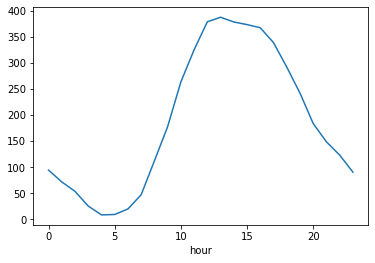

In [420]:
# Celda 2.2 - "workingday"=0 escriba su código y hallazgos 
bikes[bikes['workingday'] == 0].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour'>

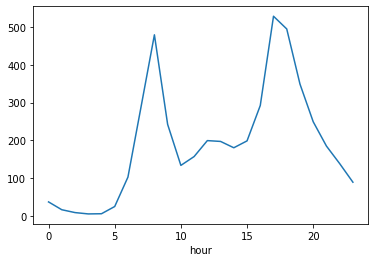

In [421]:
# Celda 2.3 - "workingday"=1 escriba su código y hallazgos 
bikes[bikes['workingday'] == 1].groupby('hour').total.mean().plot()

<AxesSubplot:xlabel='hour', ylabel='total'>

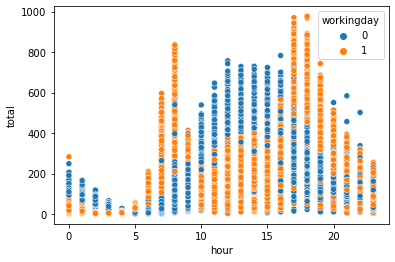

In [422]:
sns.scatterplot(data=bikes, x='hour', y='total', hue='workingday')

Observaciones:
* En días no laborales hay una tendencia de aumento de alquiler desde las 10 a 20 horas aproximadamente, presentando un pico de alquiler alrededor de las 15 horas.
* En días laborales hay picos de alquiler notables a las 5-10 horas y 15-20 horas, esto podría tener relación con las jornadas laborales y el tránsito de las personas durante la entrada y salida de sus centros de trabajo.
* Además entre las 10-15 horas existe mayor cantidad de alquiler en días no laborales comparado a días laborales.


### Punto 3 - Regresión lineal
En la celda 3 ajuste un modelo de regresión lineal a todo el conjunto de datos, utilizando "total" como variable de respuesta y "hour" y "workingday" como las únicas variables predictoras. Luego, imprima los coeficientes e interprételos. ¿Cuáles son las limitaciones de la regresión lineal en este caso?

In [423]:
# Celda 3
X = bikes[['hour', 'workingday']]
y = bikes['total']

lr = LinearRegression()
lr.fit(X.values,y.values)

print(f'W: {lr.coef_}, b:{lr.intercept_}')
print(f'R2: {lr.score(X.values, y.values)}')
print(f'MSE: {mean_squared_error(y.values, lr.predict(X.values))}')
print(f'RMSE: {mean_squared_error(y.values, lr.predict(X.values), squared=False)}')

W: [10.49206282  4.07248627], b:67.70595026191623
R2: 0.16059115011434855
MSE: 27541.255252498402
RMSE: 165.95558216733295


<AxesSubplot:>

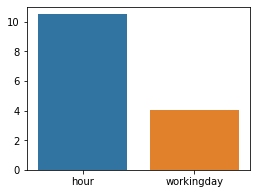

In [424]:
fig, axes=plt.subplots(1,1, figsize=(4, 3))
sns.barplot(x = X.columns.to_numpy(), y= lr.coef_.ravel(), ax=axes)

* Los coeficientes de la regresión lineal nos da el peso/importancia que tiene cada variable con respecto a la salida, en este caso el modelo le da un peso de 10 a la variable hora y un peso de 4 a la variable workingday, es decir la hora tiene mayor contribución a la hora de predecir el total de alquileres.
* Con una regresión lineal no se logra predecir correctamente, presenta un R2 muy bajo y un MSE relativamente alto. Esto porque la relación entre las variables predictoras y la salida no se lineal.


### Punto 4 - Árbol de decisión manual
En la celda 4 cree un árbol de decisiones para pronosticar la variable "total" iterando **manualmente** sobre las variables "hour" y  "workingday". El árbol debe tener al menos 6 nodos finales.

In [425]:
## FUNCIONES

# Definición de la función que calcula el mse
def get_mse(ytrue, yhat):
    n = len(ytrue)
    r = ytrue - yhat 
    r = r ** 2
    r = np.sum(r)
    return r / n

def ma(x: np.array, window: int) -> np.array:
    """
    Calculates the moving average of the given list. 
    """
    return np.convolve(x, np.ones(window), 'valid') / window
    
# Definición de la función best_split para calcular cuál es la mejor variable y punto de cortepara hacer la bifurcación del árbol
def best_split(X, y):
    
    features = range(X.shape[1])
    
    best_split = [None, None, get_mse(y, np.mean(y))]  # j, split, gain
    
    # Creating a dataset for spliting
    df = X.copy()
    df['Y'] = y
            
    # Para todas las varibles 
    for j in features:
        
        # Droping missing values
        Xdf = df.dropna().sort_values(X.columns[j])
        # Sorting the values and getting the rolling average
        
        xmeans = ma(Xdf.iloc[:, j].unique(), 2)
    
        for value in xmeans:
            # Getting the left and right ys 
            left_y = Xdf[Xdf.iloc[:, j]<value]['Y'].values
            right_y = Xdf[Xdf.iloc[:, j]>=value]['Y'].values

            # Getting the means 
            left_mean = np.mean(left_y)
            right_mean = np.mean(right_y)

            # Getting the left and right residuals 
            res_left = left_y - left_mean 
            res_right = right_y - right_mean

            # Concatenating the residuals 
            r = np.concatenate((res_left, res_right), axis=None)

            # Calculating the mse 
            n = len(r)
            r = r ** 2
            r = np.sum(r)
            mse = r / n

            # Checking if this is the best split so far 
            if mse < best_split[2]:
                best_split = [j, value, mse]
    
    return best_split

# Definición de la función tree_grow para hacer un crecimiento recursivo del árbol

def tree_grow(X, y, level=0, min_gain=0.001, max_depth=None):
    
    # Si solo es una observación
    if X.shape[0] == 1:
        tree = dict(y_pred=y.iloc[:1].values[0], level=level, split=-1, n_samples=1, gain=0)
        return tree
            
    # Calcular la mejor división
    j, split, gain = best_split(X, y)
    
    if j is not None:
        
        # Guardar el árbol y estimar la predicción
        y_pred = y.mean()
    
        tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=gain)
        # Revisar el criterio de parada 
        if gain < min_gain:
            return tree
        if max_depth is not None:
            if level >= max_depth:
                return tree   
            
        # Continuar creando la partición
        filter_l = X.iloc[:, j] < split
        X_l, y_l = X.loc[filter_l], y.loc[filter_l]
        X_r, y_r = X.loc[~filter_l], y.loc[~filter_l]
        tree['split'] = [j, split]

        # Siguiente iteración para cada partición

        if len(X_l)>0:
            tree['sl'] = tree_grow(X_l, y_l, level + 1, min_gain=min_gain, max_depth=max_depth)
        if len(X_r)>0:
            tree['sr'] = tree_grow(X_r, y_r, level + 1, min_gain=min_gain, max_depth=max_depth)

        return tree
    else:
        y_pred = y.mean()
        tree = dict(y_pred=y_pred, level=level, split=-1, n_samples=X.shape[0], gain=0)
        return tree

# Definición de la función tree_predict para hacer predicciones según las variables 'X' y el árbol 'tree'

def tree_predict(X, tree):
    
    predicted = np.ones(X.shape[0])

    # Revisar si es el nodo final
    if tree['split'] == -1:
        predicted = predicted * tree['y_pred']
 
    else:
        
        j, split = tree['split']
        filter_l = (X.iloc[:, j] < split)
        X_l = X.loc[filter_l]
        X_r = X.loc[~filter_l]

        if X_l.shape[0] == 0:  # Si el nodo izquierdo está vacio solo continua con el derecho 
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])
        elif X_r.shape[0] == 0:  #  Si el nodo derecho está vacio solo continua con el izquierdo
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
        else:
            predicted[filter_l] = tree_predict(X_l, tree['sl'])
            predicted[~filter_l] = tree_predict(X_r, tree['sr'])

    return predicted


In [426]:
# Celda 4

X = bikes[['hour', 'workingday']]
y = bikes['total']

dt_tree = tree_grow(X, y, level=0, min_gain=0.01, max_depth=10)
dt_tree



{'y_pred': 191.57413191254824,
 'level': 0,
 'split': [0, 6.5],
 'n_samples': 10886,
 'gain': 22567.731076849588,
 'sl': {'y_pred': 32.58203249442498,
  'level': 1,
  'split': [0, 5.5],
  'n_samples': 3139,
  'gain': 1242.1585299291187,
  'sl': {'y_pred': 25.177719821162444,
   'level': 2,
   'split': [0, 1.5],
   'n_samples': 2684,
   'gain': 754.3758482230121,
   'sl': {'y_pred': 44.51045104510451,
    'level': 3,
    'split': [1, 0.5],
    'n_samples': 909,
    'gain': 942.1219924254137,
    'sl': {'y_pred': 83.2,
     'level': 4,
     'split': [0, 0.5],
     'n_samples': 290,
     'gain': 1694.6071343638528,
     'sl': {'y_pred': 94.48965517241379,
      'level': 5,
      'split': -1,
      'n_samples': 145,
      'gain': 0},
     'sr': {'y_pred': 71.9103448275862,
      'level': 5,
      'split': -1,
      'n_samples': 145,
      'gain': 0}},
    'sr': {'y_pred': 26.38449111470113,
     'level': 4,
     'split': [0, 0.5],
     'n_samples': 619,
     'gain': 422.448746660919,
     

In [427]:
tree_predict(X, dt_tree)

array([ 94.48965517,  71.91034483,  53.74825175, ..., 184.85530547,
       138.34405145,  88.99678457])

In [428]:
y_predict = tree_predict(X, dt_tree)


print(f'MSE: {mean_squared_error(y.values, y_predict)}')
print(f'RMSE: {mean_squared_error(y.values, y_predict, squared=False)}')

MSE: 11329.31152387664
RMSE: 106.43923864758072


### Punto 5 - Árbol de decisión con librería
En la celda 5 entrene un árbol de decisiones con la **librería sklearn**, usando las variables predictoras "hour" y "workingday" y calibre los parámetros que considere conveniente para obtener un mejor desempeño. Comente el desempeño del modelo con alguna métrica de desempeño de modelos de regresión y compare desempeño con el modelo del punto 3.

Text(0, 0.5, 'MSE')

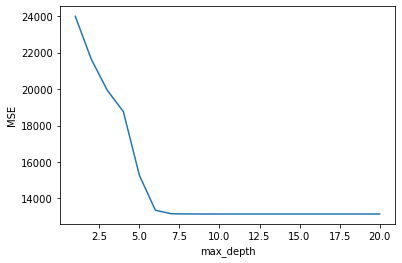

In [429]:
# Celda 5

# Calibracion de solo el max_depth

# Lista de valores para calibrar el criterio de parada de máxima profundidad (max_depth)
max_depth_range = range(1, 21)
mse_scores = []

for depth in max_depth_range:
    clf = DecisionTreeRegressor(max_depth=depth, random_state=1)
    mse_scores.append(cross_val_score(clf, X.values, y.values, cv=10, scoring='neg_mean_squared_error').mean())
    
plt.plot(max_depth_range, np.array(mse_scores)*-1)
plt.xlabel('max_depth')
plt.ylabel('MSE')

In [430]:
print(f'Best Hyperparameter max_depth={max_depth_range[8]}, MSE= {mse_scores[8]*-1}')

Best Hyperparameter max_depth=9, MSE= 13143.878482047303


In [431]:
## Calibracion con gridSearchCV

param = {'max_depth': np.arange(1, 21),
         'min_samples_split': [2, 5, 10, 14, 20],
         'min_samples_leaf': [1, 2, 4, 6, 10],
         'max_leaf_nodes': [None, 5, 10, 20]}

grid_search=GridSearchCV(estimator=DecisionTreeRegressor(),param_grid=param,cv=10,n_jobs=-1,verbose=2, scoring='neg_mean_squared_error')
grid_search.fit(X.values, y.values)

print(f'Best params: {grid_search.best_params_}')
print(f'Best estimator: {grid_search.best_estimator_}')

Fitting 10 folds for each of 2000 candidates, totalling 20000 fits
Best params: {'max_depth': 10, 'max_leaf_nodes': None, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best estimator: DecisionTreeRegressor(max_depth=10)


In [432]:
# best decisionTree

clf = DecisionTreeRegressor(max_depth=10, random_state=1)
mse_dt = cross_val_score(clf, X.values, y.values, cv=10, scoring='neg_mean_squared_error').mean()
print(f'MSE: {mse_dt*-1}')
print(f'RMSE: {np.sqrt(mse_dt*-1)}')


MSE: 13143.121883295113
RMSE: 114.64345547520414


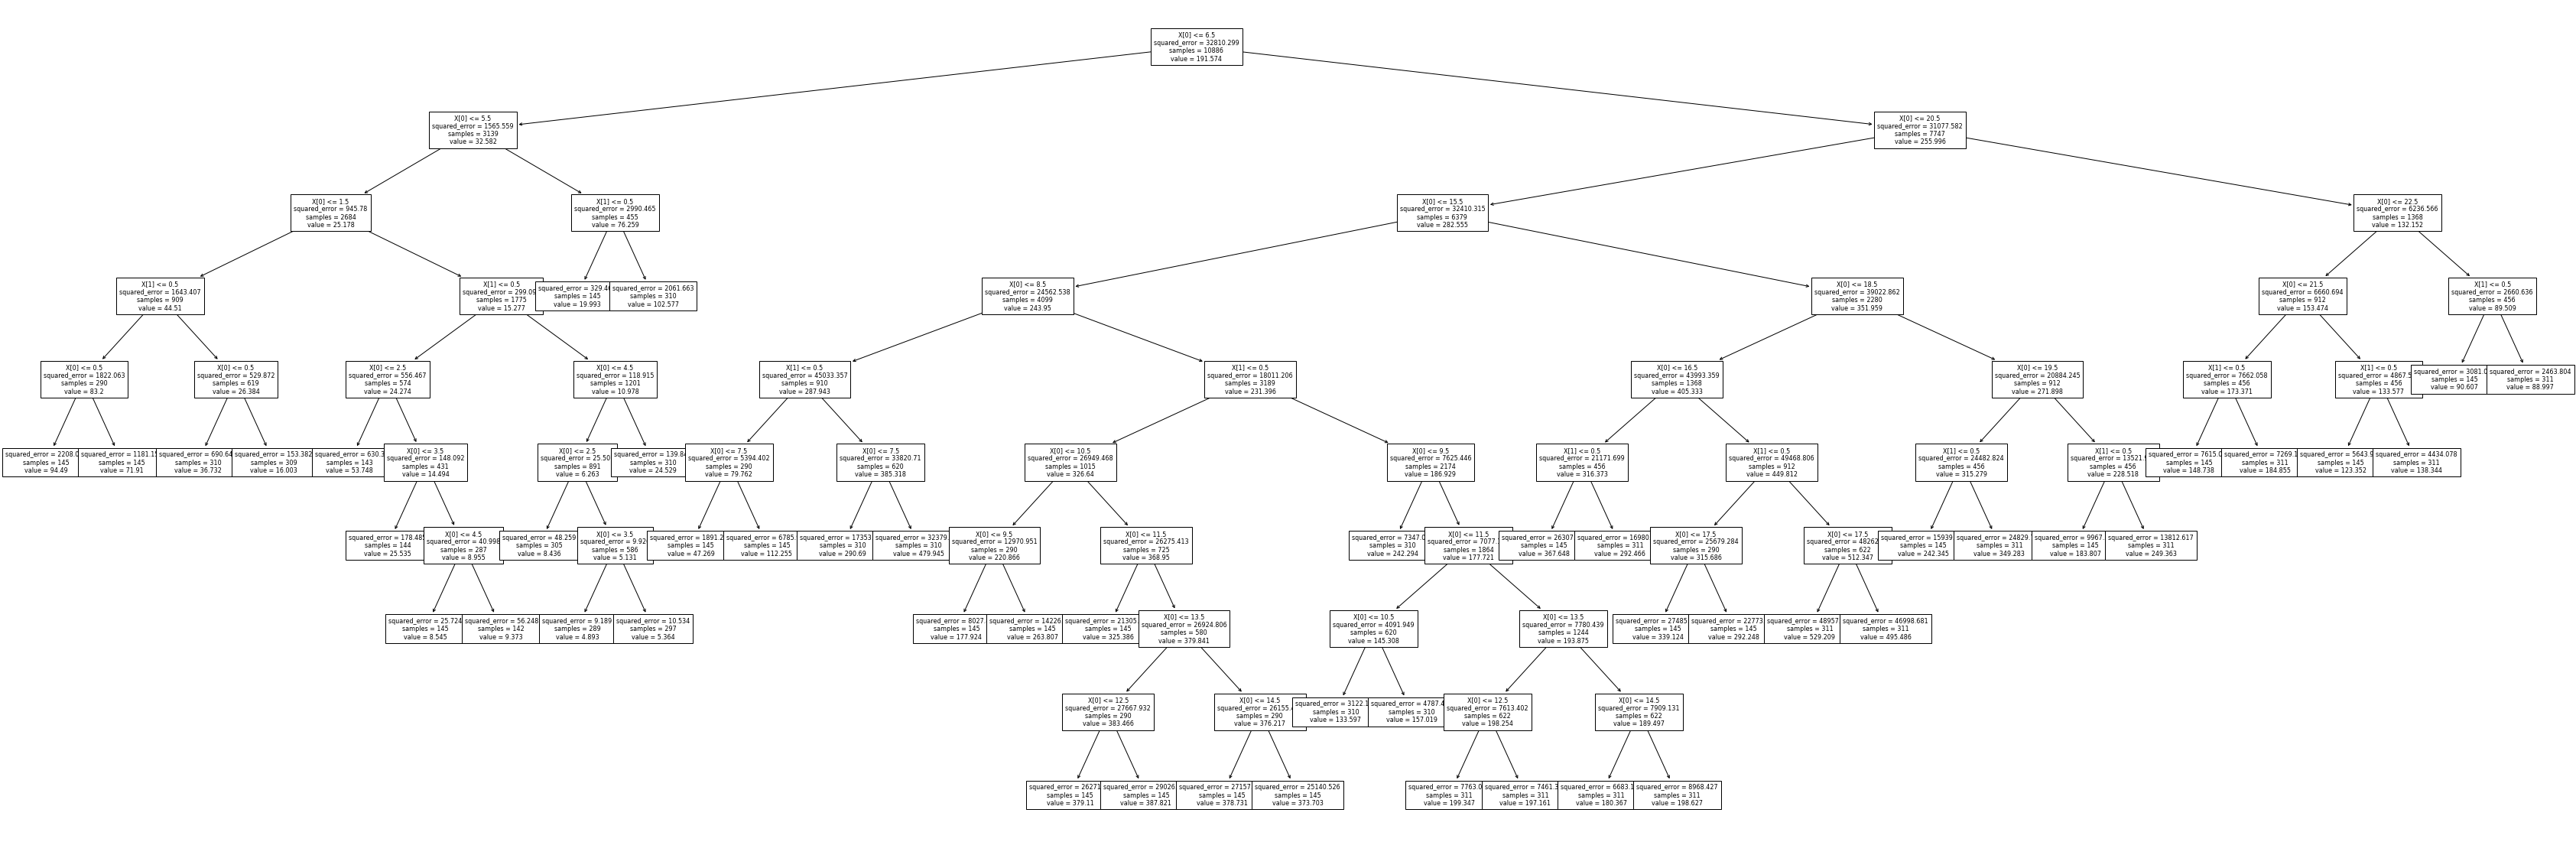

In [433]:
from sklearn import tree
clf = DecisionTreeRegressor(max_depth=10, random_state=1)
clf.fit(X.values, y.values)

fig, axes=plt.subplots(1,1, figsize=(60, 20))
tree.plot_tree(clf, ax=axes, fontsize=8)

plt.show()

* Con un árbol de decisión se logra un MSE de 13143, el cual tiene un mejor desempeño que la regresión lineal.

## Parte B - Métodos de ensamblajes
En esta parte del taller se usará el conjunto de datos de Popularidad de Noticias Online. El objetivo es predecir si la notica es popular o no, la populridad esta dada por la cantidad de reacciones en redes sociales. Para más detalles puede visitar el sigueinte enlace: [datos](https://archive.ics.uci.edu/ml/datasets/online+news+popularity).

### Datos popularidad de noticias

In [434]:
# Lectura de la información de archivo .csv
df = pd.read_csv('https://raw.githubusercontent.com/albahnsen/MIAD_ML_and_NLP/main/datasets/mashable.csv', index_col=0)
df.head()

,url,timedelta,n_tokens_title,n_tokens_content,n_unique_tokens,n_non_stop_words,n_non_stop_unique_tokens,num_hrefs,num_self_hrefs,num_imgs,...,min_positive_polarity,max_positive_polarity,avg_negative_polarity,min_negative_polarity,max_negative_polarity,title_subjectivity,title_sentiment_polarity,abs_title_subjectivity,abs_title_sentiment_polarity,Popular
0,http://mashable.com/2014/12/10/cia-torture-rep...,28.0,9.0,188.0,0.732620,1.0,0.844262,5.0,1.0,1.0,...,0.200000,0.80,-0.487500,-0.60,-0.250000,0.9,0.8,0.4,0.8,1
1,http://mashable.com/2013/10/18/bitlock-kicksta...,447.0,7.0,297.0,0.653199,1.0,0.815789,9.0,4.0,1.0,...,0.160000,0.50,-0.135340,-0.40,-0.050000,0.1,-0.1,0.4,0.1,0
2,http://mashable.com/2013/07/24/google-glass-po...,533.0,11.0,181.0,0.660377,1.0,0.775701,4.0,3.0,1.0,...,0.136364,1.00,0.000000,0.00,0.000000,0.3,1.0,0.2,1.0,0
3,http://mashable.com/2013/11/21/these-are-the-m...,413.0,12.0,781.0,0.497409,1.0,0.677350,10.0,3.0,1.0,...,0.100000,1.00,-0.195701,-0.40,-0.071429,0.0,0.0,0.5,0.0,0
4,http://mashable.com/2014/02/11/parking-ticket-...,331.0,8.0,177.0,0.685714,1.0,0.830357,3.0,2.0,1.0,...,0.100000,0.55,-0.175000,-0.25,-0.100000,0.0,0.0,0.5,0.0,0


In [435]:
# Definición variable de interes y variables predictoras
X = df.drop(['url', 'Popular'], axis=1)
y = df['Popular']

In [436]:
df['Popular'].value_counts()

1    3000
0    3000
Name: Popular, dtype: int64

In [437]:
# División de la muestra en set de entrenamiento y prueba
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, stratify=y, random_state=1)

### Punto 6 - Árbol de decisión y regresión logística
En la celda 6 construya un árbol de decisión y una regresión logística. Para el árbol calibre al menos un parámetro y evalúe el desempeño de cada modelo usando las métricas de Accuracy y F1-Score.

In [438]:
lr = LogisticRegression()
lr.fit(X_train.values, y_train.values)

y_predict = lr.predict(X_test.values)

print("Logistic Regression")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")

Logistic Regression
Accuracy: 0.6111111111111112
F1_score: 0.5934959349593496


In [439]:
## Decision Tree
param = {'max_depth': np.arange(1, 40),
         'min_samples_split': [2, 5, 10, 20],
         'min_samples_leaf': [1, 2, 6, 10]
        }


grid_search=GridSearchCV(estimator=DecisionTreeClassifier(),param_grid=param,cv=5,n_jobs=-1,verbose=2, scoring='accuracy')
grid_search.fit(X_train.values, y_train.values)

print(f'Best params: {grid_search.best_params_}')
print(f'Best estimator: {grid_search.best_estimator_}')

Fitting 5 folds for each of 624 candidates, totalling 3120 fits
Best params: {'max_depth': 1, 'min_samples_leaf': 1, 'min_samples_split': 2}
Best estimator: DecisionTreeClassifier(max_depth=1)


In [440]:
clf = DecisionTreeClassifier(max_depth=1)
clf.fit(X_train.values, y_train.values)

y_predict = clf.predict(X_test.values)

print("Decision Tree Classifier")
print(f'Accuracy: {accuracy_score(y_test.values, y_predict)}')
print(f"F1_score: {f1_score(y_test.values, y_predict)}")

Decision Tree Classifier
Accuracy: 0.6244444444444445
F1_score: 0.6132723112128146


### Punto 7 - Votación Mayoritaria
En la celda 7 elabore un esamble con la metodología de **Votación mayoritaria** compuesto por 300 muestras bagged para cada uno de los siguientes escenarios:

-100 árboles de decisión donde max_depth = None\
-100 árboles de decisión donde max_depth = 2\
-100 regresiones logísticas

Evalúe los modelos utilizando las métricas de Accuracy y F1-Score.

In [441]:
# Celda 7

def get_idx_bootstrap_sample(max_samples, X):
    n_samples = X.shape[0]
    if max_samples is None:
        return np.random.choice(a=n_samples, size=n_samples, replace=True)
    else:
        return np.random.choice(a=n_samples, size=max_samples, replace=True)

In [442]:
# Ensamble 100 arboles + 100 arboles + 100 regresiones logisticas
n_estimators = 300

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

models = {}
max_samples = None

for i in range(n_estimators):

    #bootstrap
    idx = get_idx_bootstrap_sample(max_samples, X_train)

    #models
    if i <100:
        models[i] = DecisionTreeClassifier(max_depth=None, random_state=seeds[i])
        models[i].fit(X_train.iloc[idx], y_train.iloc[idx])
    if i >=100 and i<200:
        models[i] = DecisionTreeClassifier(max_depth=2, random_state=seeds[i])
        models[i].fit(X_train.iloc[idx], y_train.iloc[idx])
    if i >=200 and i<300:
        models[i] = LogisticRegression(random_state=seeds[i])
        models[i].fit(X_train.iloc[idx], y_train.iloc[idx])
    


In [443]:
# Desempeño individual de cada modelo del ensamble
accuracys = []
f1s = []
for i in range(n_estimators):
    y_predict = models[i].predict(X_test.values)
    acc = accuracy_score(y_test.values, y_predict)
    f1 = f1_score(y_test.values, y_predict)
    accuracys.append(acc)
    f1s.append(f1)
    print(f'Model {i} Accuracy={acc}, F1={f1}')

Model 0 Accuracy=0.5444444444444444, F1=0.536723163841808
Model 1 Accuracy=0.5611111111111111, F1=0.5546786922209695
Model 2 Accuracy=0.5561111111111111, F1=0.554874651810585
Model 3 Accuracy=0.5294444444444445, F1=0.5179282868525896
Model 4 Accuracy=0.5705555555555556, F1=0.5722191477587162
Model 5 Accuracy=0.5811111111111111, F1=0.5696347031963469
Model 6 Accuracy=0.5705555555555556, F1=0.573634859349145
Model 7 Accuracy=0.5727777777777778, F1=0.5777045579352004
Model 8 Accuracy=0.5561111111111111, F1=0.5518788558609086
Model 9 Accuracy=0.5594444444444444, F1=0.5616362631288006
Model 10 Accuracy=0.5555555555555556, F1=0.5348837209302325
Model 11 Accuracy=0.5611111111111111, F1=0.5576707726763718
Model 12 Accuracy=0.5588888888888889, F1=0.5509049773755657
Model 13 Accuracy=0.5683333333333334, F1=0.5700055340343111
Model 14 Accuracy=0.5716666666666667, F1=0.5779967159277504
Model 15 Accuracy=0.5683333333333334, F1=0.5666480758505298
Model 16 Accuracy=0.565, F1=0.5704882062534284
Model 

Model 143 Accuracy=0.6122222222222222, F1=0.5502577319587629
Model 144 Accuracy=0.6116666666666667, F1=0.5493230174081238
Model 145 Accuracy=0.6144444444444445, F1=0.5618686868686869
Model 146 Accuracy=0.6038888888888889, F1=0.5318450426789232
Model 147 Accuracy=0.6288888888888889, F1=0.6200227531285551
Model 148 Accuracy=0.6261111111111111, F1=0.6116560877091749
Model 149 Accuracy=0.6244444444444445, F1=0.6132723112128146
Model 150 Accuracy=0.6244444444444445, F1=0.6132723112128146
Model 151 Accuracy=0.6177777777777778, F1=0.5990675990675991
Model 152 Accuracy=0.6244444444444445, F1=0.6132723112128146
Model 153 Accuracy=0.6244444444444445, F1=0.6132723112128146
Model 154 Accuracy=0.625, F1=0.6127366609294321
Model 155 Accuracy=0.6244444444444445, F1=0.6132723112128146
Model 156 Accuracy=0.6133333333333333, F1=0.55893536121673
Model 157 Accuracy=0.6244444444444445, F1=0.6132723112128146
Model 158 Accuracy=0.6261111111111111, F1=0.6010669828097214
Model 159 Accuracy=0.6244444444444445, 

Model 294 Accuracy=0.6066666666666667, F1=0.5703883495145631
Model 295 Accuracy=0.6111111111111112, F1=0.5818399044205496
Model 296 Accuracy=0.6077777777777778, F1=0.6069042316258353
Model 297 Accuracy=0.6116666666666667, F1=0.5761067313523349
Model 298 Accuracy=0.6055555555555555, F1=0.5947488584474886
Model 299 Accuracy=0.6038888888888889, F1=0.5842565597667638


Text(0.5, 0, 'Estimator')

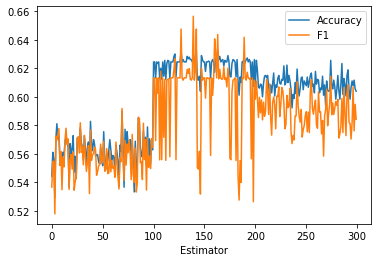

In [444]:
plt.plot(range(n_estimators), accuracys)
plt.plot(range(n_estimators), f1s)
plt.legend(['Accuracy', 'F1'])
plt.xlabel('Estimator')


In [445]:
#predict dataframe
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = models[i].predict(X_test.values)

# Desempeño global
# Votación mayoritaria
y_pred = (y_pred_df.sum(axis=1) >= (n_estimators / 2)).astype(np.int)

# Desempeño al hacer votación mayoritaria
print("Ensamble Classifier")
print(f'Accuracy: {accuracy_score(y_test.values, y_pred)}')
print(f"F1_score: {f1_score(y_test.values, y_pred)}")

Ensamble Classifier
Accuracy: 0.6238888888888889
F1_score: 0.6038619075482738


### Punto 8 - Votación Ponderada
En la celda 8 elabore un ensamble con la metodología de **Votación ponderada** compuesto por 300 muestras bagged para los mismos tres escenarios del punto 7. Evalúe los modelos utilizando las métricas de Accuracy y F1-Score

In [446]:
# Celda 8
samples_oob = []
samples = []
    
# Ensamble 100 arboles + 100 arboles + 100 regresiones logisticas
n_estimators = 300

np.random.seed(123) 
seeds = np.random.randint(1, 10000, size=n_estimators)

models = {}
max_samples = None

for i in range(n_estimators):
    # samples
    n_samples = X_train.shape[0]
        
    #bootstrap
    idx = get_idx_bootstrap_sample(max_samples, X_train)

    # Obtención de las observaciones fuera de la bolsa "out-of-bag" para cada muestra
    samples_oob.append(sorted(set(range(n_samples)) - set(idx)))    
    samples.append(idx)
    
    #models
    if i <100:
        models[i] = DecisionTreeClassifier(max_depth=None, random_state=seeds[i])
        models[i].fit(X_train.iloc[idx], y_train.iloc[idx])
    if i >=100 and i<200:
        models[i] = DecisionTreeClassifier(max_depth=2, random_state=seeds[i])
        models[i].fit(X_train.iloc[idx], y_train.iloc[idx])
    if i >=200 and i<300:
        models[i] = LogisticRegression(random_state=seeds[i])
        models[i].fit(X_train.iloc[idx], y_train.iloc[idx])
    

In [447]:
# Estimación de los errores OOB para cada clasificador
errors = np.zeros(n_estimators)

for i in range(n_estimators):
    y_pred_ = models[i].predict(X_train.iloc[samples_oob[i]])
    errors[i] = 1 - accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)

Text(0, 0.5, 'Error')

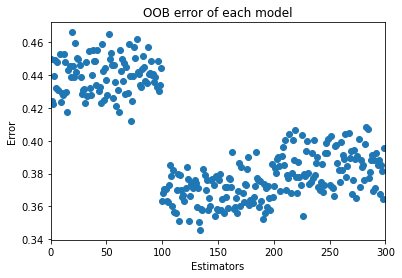

In [448]:
plt.scatter(range(n_estimators), errors)
plt.xlim([0, n_estimators])
plt.title('OOB error of each model')
plt.xlabel("Estimators")
plt.ylabel("Error")

In [449]:
# accuracy y f1 OOB de cada modelo

accuracys = []
f1s = []
for i in range(n_estimators):
    y_pred_ = models[i].predict(X_train.iloc[samples_oob[i]])
    acc = accuracy_score(y_train.iloc[samples_oob[i]], y_pred_)
    f1 = f1_score(y_train.iloc[samples_oob[i]], y_pred_)
    
    accuracys.append(acc)
    f1s.append(f1)
    print(f'Model {i} Accuracy={acc}, F1={f1}')
    
    

Model 0 Accuracy=0.5501302083333334, F1=0.537173476222371
Model 1 Accuracy=0.5759368836291914, F1=0.5708582834331337
Model 2 Accuracy=0.5779054916985952, F1=0.574372182871861
Model 3 Accuracy=0.5602883355176933, F1=0.5565102445472572
Model 4 Accuracy=0.5507433742727861, F1=0.5559105431309904
Model 5 Accuracy=0.5679172056921087, F1=0.5662337662337661
Model 6 Accuracy=0.5520156046814044, F1=0.5528877352368593
Model 7 Accuracy=0.5690642902609803, F1=0.5606748864373783
Model 8 Accuracy=0.5471938775510204, F1=0.5442875481386393
Model 9 Accuracy=0.5765239948119325, F1=0.5684071381361534
Model 10 Accuracy=0.5706771860618014, F1=0.5626255860683189
Model 11 Accuracy=0.5723350253807107, F1=0.5744949494949495
Model 12 Accuracy=0.547244094488189, F1=0.5369127516778522
Model 13 Accuracy=0.55198973042362, F1=0.5537084398976981
Model 14 Accuracy=0.5700451904454487, F1=0.575796178343949
Model 15 Accuracy=0.5827290705339486, F1=0.5965583173996176
Model 16 Accuracy=0.5569053708439897, F1=0.5502920181700

Model 150 Accuracy=0.6421471172962226, F1=0.6380697050938338
Model 151 Accuracy=0.624025974025974, F1=0.6090479405806887
Model 152 Accuracy=0.6201799485861182, F1=0.6189555125725338
Model 153 Accuracy=0.6423499031633312, F1=0.6462324393358876
Model 154 Accuracy=0.6353697749196141, F1=0.6242544731610338
Model 155 Accuracy=0.6442738323736404, F1=0.6563658838071693
Model 156 Accuracy=0.6284610431423052, F1=0.5760470242468773
Model 157 Accuracy=0.6340983606557377, F1=0.630952380952381
Model 158 Accuracy=0.6281635301752109, F1=0.6078028747433265
Model 159 Accuracy=0.6408450704225352, F1=0.6373626373626373
Model 160 Accuracy=0.6230366492146597, F1=0.6559139784946236
Model 161 Accuracy=0.6236421725239617, F1=0.6361951822112415
Model 162 Accuracy=0.6281635301752109, F1=0.6257348138471588
Model 163 Accuracy=0.607051282051282, F1=0.6331538001196889
Model 164 Accuracy=0.641781270464964, F1=0.6224982746721877
Model 165 Accuracy=0.640675763482781, F1=0.6434558349451968
Model 166 Accuracy=0.63500325

Text(0.5, 0, 'Estimator')

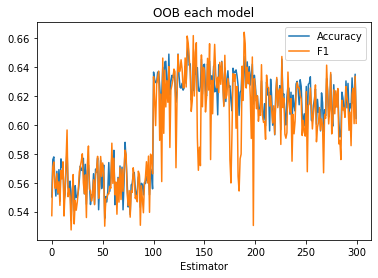

In [450]:
plt.plot(range(n_estimators), accuracys)
plt.plot(range(n_estimators), f1s)
plt.title("OOB each model")
plt.legend(['Accuracy', 'F1'])
plt.xlabel('Estimator')


Text(0, 0.5, 'Pesos')

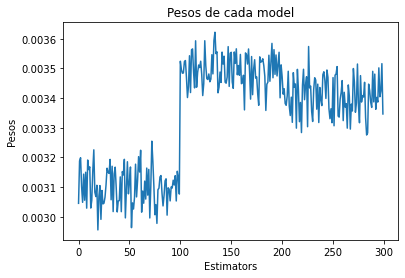

In [451]:
# Obtención de los pesos alpha de cada modelo de acuerdo al error OOB
alpha = (1 - errors) / (1 - errors).sum()

plt.plot(range(n_estimators), alpha)
plt.title('Pesos de cada model')
plt.xlabel("Estimators")
plt.ylabel("Pesos")

In [452]:
#predict dataframe
y_pred_df = pd.DataFrame(index=X_test.index, columns=list(range(n_estimators)))
for i in range(n_estimators):
    y_pred_df.iloc[:, i] = models[i].predict(X_test.values)

# Desempeño global
# Ponderación de las predicciones con los pesos alpha
weighted_sum_1 = ((y_pred_df) * alpha).sum(axis=1)
y_pred = (weighted_sum_1 >= 0.5).astype(np.int)

# Desempeño al hacer votación mayoritaria
print("Ensamble Classifier")
print(f'Accuracy: {accuracy_score(y_test.values, y_pred)}')
print(f"F1_score: {f1_score(y_test.values, y_pred)}")

Ensamble Classifier
Accuracy: 0.6238888888888889
F1_score: 0.601060695344726


### Punto 9 - Comparación y análisis de resultados
En la celda 9 comente sobre los resultados obtenidos con las metodologías usadas en los puntos 7 y 8, compare los resultados y enuncie posibles ventajas o desventajas de cada una de ellas.

Se obtuvo estos resultados en los 2 ensambles

Ensamble Classifier con votacion mayoritaria
* Accuracy: 0.6238888888888889
* F1_score: 0.6038619075482738

Ensamble Classifier con votacion ponderada
* Accuracy: 0.6238888888888889
* F1_score: 0.601060695344726
    

* Observamos que el accuracy en ambos ensambles es igual, por lo que podemos elegir cualquier de los dos
* El ensamble con votación ponderada presenta ligeramente mejor F1, en ambos casos el F1 es simular
* Para estos datos no se logró encontrar una gran diferencia entre ambos métodos de predicción
* Una ventaja del uso de la votación ponderada es que considera el error de predicción de cada modelo como medida de confiabilidad del modelo, es decir un peor modelo tendrá menos contribución a la producción global.
* Desventaja de la votación ponderada puede ser el paso adicional del cálculo del error de predicción con las muestras oob en cada modelo y asignarle un peso
* La ventaja del modelo de votación mayoritaria es su simplicidad, es decir no se da importancia a la precisión de los modelos individuales.
